In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import xml.etree.ElementTree as ET
from PIL import Image
from PIL import ImageOps
import shutil
import random
import json
from os.path import join
from pathlib import Path
from tqdm import tqdm

crop and resize objects from all .jpg images

In [6]:
# Get the list of all files and directories
img_path = r"..\dataset-ninja\argoverse-hd\train\img"
ann_path = r"..\dataset-ninja\argoverse-hd\train\ann"
dir_list = os.listdir(img_path)
print("Files and directories in '", img_path, "' :")
# prints all files
print(len(dir_list))

# len(dir_list)
for lcv in tqdm(range(len(dir_list))):
    curr_file = dir_list[lcv]

    # Opening JSON file
    f = open(join(ann_path, curr_file + str(".json")))
    
    # returns JSON object as a dictionary
    data = json.load(f)
    f.close()

    # Open image in PIL
    im = Image.open(join(r"..\dataset-ninja\argoverse-hd\train\img", curr_file))
    
    # Iterating through the json list
    lcv2 = 0
    for i in data['objects']:
        # print(i)
        # print(i['classTitle'])
        # print(i['points']['exterior'])
        curr_class = i['classTitle']
        curr_box = i['points']['exterior']

        left = curr_box[0][0]
        top = curr_box[0][1]
        right = curr_box[1][0]
        bottom = curr_box[1][1]

        pxl_area = (right-left) * (bottom-top)
        
        if pxl_area > 5000:
            im1 = im.crop((left, top, right, bottom))

            # Craft destination filename
            dst = join(r"..\dataset-ninja\processed", curr_class, Path(curr_file).stem + "_" + str(lcv2) + ".jpg")
            lcv2 += 1

            # Move cropped file (make dir if necessary)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            im1 = ImageOps.grayscale(im1.resize((32, 32)))
            im1.save(dst)


Files and directories in ' ..\dataset-ninja\argoverse-hd\train\img ' :
39384


100%|██████████| 39384/39384 [39:11<00:00, 16.75it/s] 


create separate train, test, validate folders

In [3]:
source_folder = "../dataset-ninja/processed"
train_folder = '../dataset-ninja/train'
test_folder = '../dataset-ninja/test'
validate_folder = '../dataset-ninja/validate'

# Create destination folders if they don't exist
for folder in [train_folder, test_folder, validate_folder]:
    if not os.path.exists(folder):
        os.makedirs(folder)

# Define the split ratio
train_split = 0.8
test_split = 0.1
validate_split = 0.1

max_stop_images_train = 25

# Iterate through each category folder
for category_folder in os.listdir(source_folder):
    category_path = os.path.join(source_folder, category_folder)
    if os.path.isdir(category_path):
        # Create category subfolders in train, test, and validate folders
        train_category_folder = os.path.join(train_folder, category_folder)
        test_category_folder = os.path.join(test_folder, category_folder)
        validate_category_folder = os.path.join(validate_folder, category_folder)
        for folder in [train_category_folder, test_category_folder, validate_category_folder]:
            if not os.path.exists(folder):
                os.makedirs(folder)
        # List all files in the category folder
        files = os.listdir(category_path)
        # Shuffle the files to ensure randomness
        random.shuffle(files)
        # Calculate split indices
        train_index = int(len(files) * train_split)
        test_index = int(len(files) * (train_split + test_split))
        # Divide the files into train, test, and validate sets
        train_files = files[:train_index]
        test_files = files[train_index:test_index]
        validate_files = files[test_index:]
        # Limit the number of images in the "stop" folder for training
        if category_folder == "stop":
            if len(train_files) > max_stop_images_train:
                additional_files = train_files[max_stop_images_train:]
                test_files.extend(additional_files[:len(additional_files) // 2])
                validate_files.extend(additional_files[len(additional_files) // 2:])
                train_files = train_files[:max_stop_images_train]
        # Move files to the corresponding category folders within train, test, and validate sets
        for file in train_files:
            shutil.copy(os.path.join(category_path, file), os.path.join(train_category_folder, file))
        for file in test_files:
            shutil.copy(os.path.join(category_path, file), os.path.join(test_category_folder, file))
        for file in validate_files:
            shutil.copy(os.path.join(category_path, file), os.path.join(validate_category_folder, file))

In [4]:
source_folder = "../dataset-ninja/processed"
train_folder = '../dataset-ninja/train_unbiased'
test_folder = '../dataset-ninja/test_unbiased'
validate_folder = '../dataset-ninja/validate_unbiased'

# Create destination folders if they don't exist
for folder in [train_folder, test_folder, validate_folder]:
    if not os.path.exists(folder):
        os.makedirs(folder)

# Define the split ratio
train_split = 0.8
test_split = 0.1
validate_split = 0.1

max_stop_images_train = 25

# Iterate through each category folder
for category_folder in os.listdir(source_folder):
    category_path = os.path.join(source_folder, category_folder)
    if os.path.isdir(category_path):
        # Create category subfolders in train, test, and validate folders
        train_category_folder = os.path.join(train_folder, category_folder)
        test_category_folder = os.path.join(test_folder, category_folder)
        validate_category_folder = os.path.join(validate_folder, category_folder)
        for folder in [train_category_folder, test_category_folder, validate_category_folder]:
            if not os.path.exists(folder):
                os.makedirs(folder)
        # List all files in the category folder
        files = os.listdir(category_path)
        # Shuffle the files to ensure randomness
        random.shuffle(files)
        # Calculate split indices
        train_index = int(len(files) * train_split)
        test_index = int(len(files) * (train_split + test_split))
        # Divide the files into train, test, and validate sets
        train_files = files[:train_index]
        test_files = files[train_index:test_index]
        validate_files = files[test_index:]
        # Limit the number of images in the "stop" folder for training
        # if category_folder == "stop":
        #     if len(train_files) > max_stop_images_train:
        #         additional_files = train_files[max_stop_images_train:]
        #         test_files.extend(additional_files[:len(additional_files) // 2])
        #         validate_files.extend(additional_files[len(additional_files) // 2:])
        #         train_files = train_files[:max_stop_images_train]
        # Move files to the corresponding category folders within train, test, and validate sets
        for file in train_files:
            shutil.copy(os.path.join(category_path, file), os.path.join(train_category_folder, file))
        for file in test_files:
            shutil.copy(os.path.join(category_path, file), os.path.join(test_category_folder, file))
        for file in validate_files:
            shutil.copy(os.path.join(category_path, file), os.path.join(validate_category_folder, file))

Create datasets for binary testing

In [6]:
source_folder = "../dataset-ninja/processed"
train_folder = '../dataset-ninja/train_binary'
test_folder = '../dataset-ninja/test_binary'
validate_folder = '../dataset-ninja/validate_binary'

# Create destination folders if they don't exist
for folder in [train_folder, test_folder, validate_folder]:
    if not os.path.exists(folder):
        os.makedirs(folder)

# Define binary classes to use
# binary_classes = ['car', 'bicycle']
# binary_classes = ['stop sign', 'traffic light']
binary_classes = ['bicycle', 'bus']

# Define number of samples in both test and validation datasets
test_samples = 100
val_samples = 100

# Iterate through each category folder
for category_folder in binary_classes:
    category_path = os.path.join(source_folder, category_folder)
    if os.path.isdir(category_path):
        # Create category subfolders in train, test, and validate folders
        train_category_folder = os.path.join(train_folder, category_folder)
        test_category_folder = os.path.join(test_folder, category_folder)
        validate_category_folder = os.path.join(validate_folder, category_folder)
        for folder in [train_category_folder, test_category_folder, validate_category_folder]:
            if not os.path.exists(folder):
                os.makedirs(folder)
        # List all files in the category folder
        files = os.listdir(category_path)
        # Shuffle the files to ensure randomness
        random.shuffle(files)
        # Make sure enough files exist for dividing
        if len(files) > (test_samples + val_samples):
            # Divide the files into train, test, and validate sets
            test_files = files[:test_samples]
            validate_files = files[test_samples:test_samples+val_samples]
            train_files = files[test_samples+val_samples:]
            # Move files to the corresponding category folders within train, test, and validate sets
            for file in train_files:
                shutil.copy(os.path.join(category_path, file), os.path.join(train_category_folder, file))
            for file in test_files:
                shutil.copy(os.path.join(category_path, file), os.path.join(test_category_folder, file))
            for file in validate_files:
                shutil.copy(os.path.join(category_path, file), os.path.join(validate_category_folder, file))

graph for total images in the 3 folders

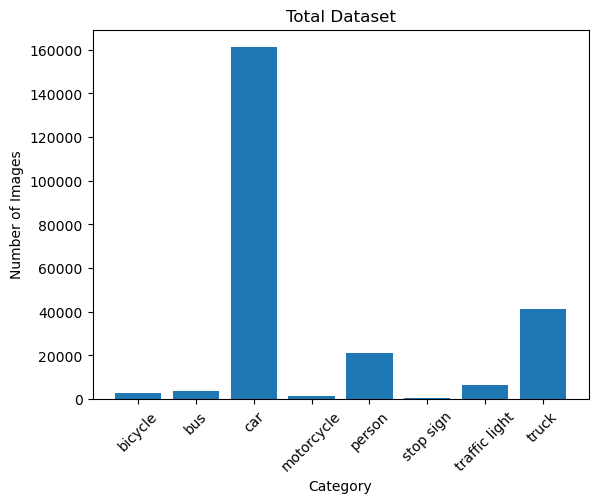

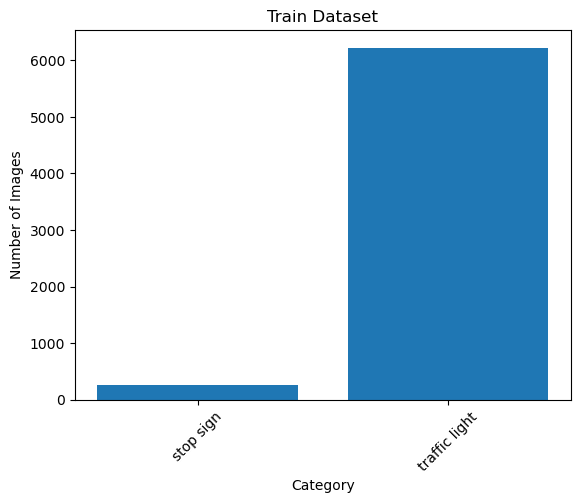

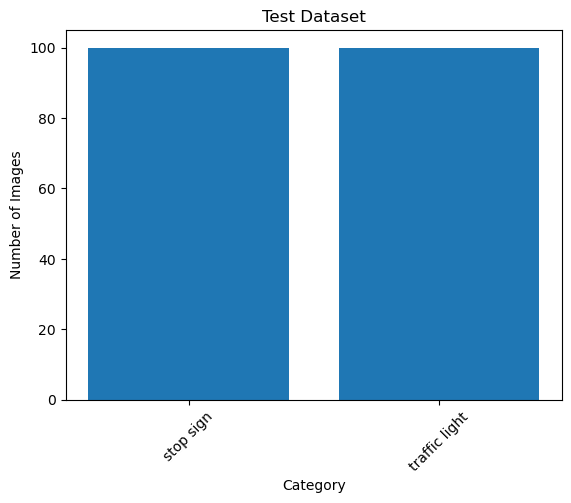

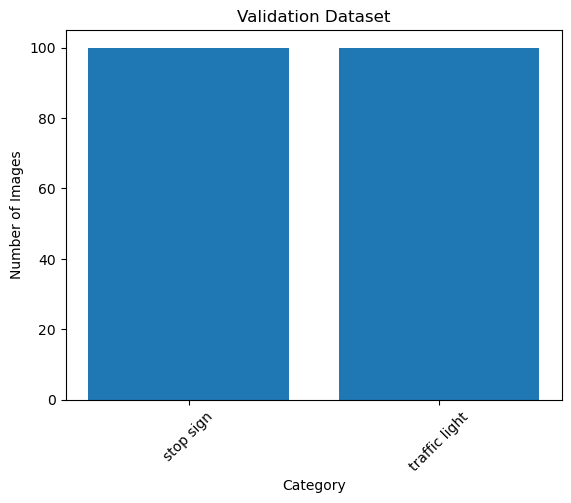

Total count:  {'bicycle': 2979, 'bus': 3520, 'car': 161225, 'motorcycle': 1404, 'person': 21332, 'stop sign': 467, 'traffic light': 6426, 'truck': 41249}
Train count:  {'stop sign': 267, 'traffic light': 6226}
Test count:  {'stop sign': 100, 'traffic light': 100}
Valid count:  {'stop sign': 100, 'traffic light': 100}


In [5]:
train_folder = '../dataset-ninja/train_binary'
test_folder = '../dataset-ninja/test_binary'
validate_folder = '../dataset-ninja/validate_binary'
total_folder = '../dataset-ninja/processed/'

# Function to count the total number of images in each category folder
def count_images(folder):
    categories = os.listdir(folder)
    category_counts = {}
    for category in categories:
        category_path = os.path.join(folder, category)
        if os.path.isdir(category_path):
            num_images = len(os.listdir(category_path))
            category_counts[category] = num_images
    return category_counts

# Count the total number of images in each category for train, test, and validate folders
train_counts = count_images(train_folder)
test_counts = count_images(test_folder)
validate_counts = count_images(validate_folder)
total_count = count_images(total_folder)

# Plot graphs
def plot_graph(counts, title):
    categories = list(counts.keys())
    values = list(counts.values())
    plt.bar(categories, values)
    plt.xlabel('Category')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

plot_graph(total_count, 'Total Dataset')
plot_graph(train_counts, 'Train Dataset')
plot_graph(test_counts, 'Test Dataset')
plot_graph(validate_counts, 'Validation Dataset')

print("Total count: ", total_count)
print("Train count: ", train_counts)
print("Test count: ", test_counts)
print("Valid count: ", validate_counts)

get mean and std for all channels to normalise

In [4]:
def calculate_channel_stats(image_paths):
    # Initialize lists to store channel-wise pixel values
    red_values = []
    green_values = []
    blue_values = []

    # Iterate through each image
    for image_path in image_paths:
        # Open the image
        image = Image.open(image_path)
        # Convert the image to RGB mode
        image_rgb = image.convert('RGB')
        # Convert the image to a numpy array
        image_array = np.array(image_rgb)
        # Separate RGB channels
        # red_channel = image_array[:, :, 0]
        # green_channel = image_array[:, :, 1]
        # blue_channel = image_array[:, :, 2]
        red_channel = image_array[:, :]
        # Append channel-wise pixel values to lists
        red_values.extend(red_channel.flatten())
        # green_values.extend(green_channel.flatten())
        # blue_values.extend(blue_channel.flatten())

    # Set default values
    red_mean = 0
    green_mean = 0
    blue_mean = 0
    red_std = 0
    green_std = 0
    blue_std = 0

    # Calculate mean and standard deviation for each channel
    red_mean = np.mean(red_values)
    # green_mean = np.mean(green_values)
    # blue_mean = np.mean(blue_values)
    red_std = np.std(red_values)
    # green_std = np.std(green_values)
    # blue_std = np.std(blue_values)

    return (red_mean, green_mean, blue_mean), (red_std, green_std, blue_std)

def get_image_paths(folder):
    image_paths = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith('.jpg'):
                image_paths.append(os.path.join(root, file))
    return image_paths

folder = '../dataset-ninja/train_binary/'
n = 6000
all_image_paths = get_image_paths(folder)
image_paths = random.sample(all_image_paths, n)
if len(image_paths) == 0:
    print("No JPEG images found in the folder.")
else:
    mean, std = calculate_channel_stats(image_paths)
    print("Mean of each channel (R, G, B):", mean)
    print("Standard deviation of each channel (R, G, B):", std)


Mean of each channel (R, G, B): (109.33673063151042, 0, 0)
Standard deviation of each channel (R, G, B): (57.554778696434944, 0, 0)
